In [1]:
"""
A simple RSI-based mean reversion strategy:
- Buy when RSI < 30 (oversold)
- Sell when RSI > 70 (overbought)

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace=True)
    df.dropna(inplace=True)
    return df

In [2]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [3]:
def rsi_signals(df, lower=30, upper=70, period=14):
    """
    Return signals based on RSI oversold/overbought logic.
    """
    df['rsi'] = compute_rsi(df['close'], period=period)
    df['signal'] = 0
    df.loc[df['rsi'] < lower, 'signal'] = 1
    df.loc[df['rsi'] > upper, 'signal'] = -1
    return df

In [4]:
def backtest_strategy(df, initial_capital=10000):
    df['returns'] = df['close'].pct_change().fillna(0)
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
    
    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy'])
        / df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return*100:.2f}%",
        "Max Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }
    return df, result

In [5]:
def plot_results(df):
    # Price + RSI + signals
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
    ax[0].plot(df.index, df['close'], label='Price')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax[0].scatter(buy_signals.index, buy_signals['close'], marker='^', label='Buy')
    ax[0].scatter(sell_signals.index, sell_signals['close'], marker='v', label='Sell')
    ax[0].set_title("RSI Mean Reversion - Price & Signals")
    ax[0].legend()
    
    ax[1].plot(df.index, df['rsi'], label='RSI')
    ax[1].axhline(30, color='gray', linestyle='--')
    ax[1].axhline(70, color='gray', linestyle='--')
    ax[1].set_title("RSI")
    ax[1].legend()
    plt.show()
    
    # Equity curve
    plt.plot(df.index, df['cumulative_market'], label='Market Returns')
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy Returns')
    plt.title("RSI Mean Reversion - Equity Curve")
    plt.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True
Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 11814.13
Total Return: 18.14%
Max Drawdown: 25.98%
Sharpe Ratio: 0.36


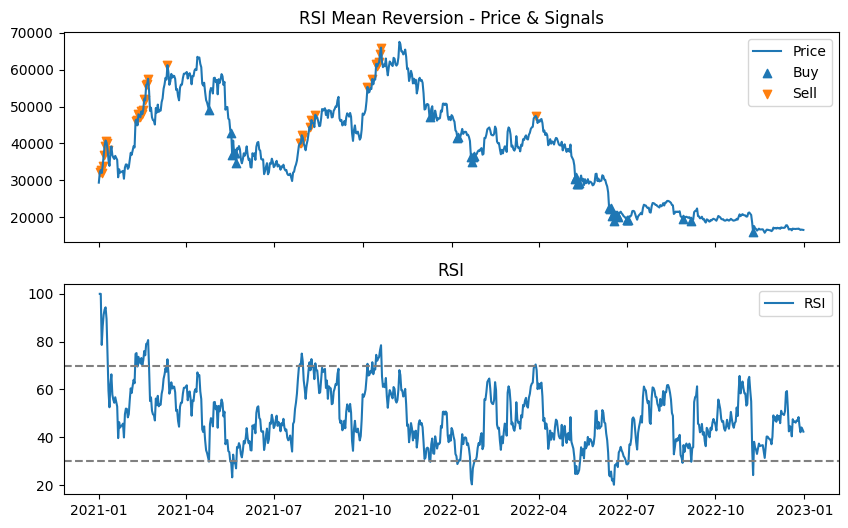

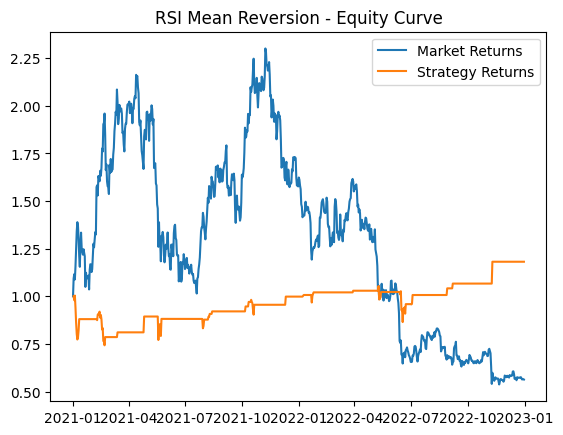

In [6]:
data = download_data("BTC-USD", "2021-01-01", "2023-01-01")
data = rsi_signals(data, lower=30, upper=70, period=14)
data, metrics = backtest_strategy(data, initial_capital=10000)

print("Performance Metrics:")
for k,v in metrics.items():
    print(f"{k}: {v}")

plot_results(data)